Paso 1: Cargar el dataset con augmentación (TensorFlow)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_dir = "colon_image_sets"
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 10000 images belonging to 2 classes.


In [7]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# Cargar modelo preentrenado sin la capa final
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')
feature_model = Model(inputs=base_model.input, outputs=base_model.output)

# Extraer features
features_list = []
labels_list = []

for i in range(len(generator)):
    x_batch, y_batch = generator[i]
    f_batch = feature_model.predict(x_batch)
    features_list.append(f_batch)
    labels_list.append(y_batch)
    
    if (i + 1) * batch_size >= generator.samples:
        break

X = np.concatenate(features_list)
y = np.concatenate(labels_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

📊 Classification Report (Test):

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1000
         1.0       0.98      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

✅ Accuracy en entrenamiento: 1.0000
✅ Accuracy en test: 0.9880
🔁 Validación cruzada (media): 0.9857
     Fold scores: [0.9845 0.989  0.986  0.979  0.99  ]


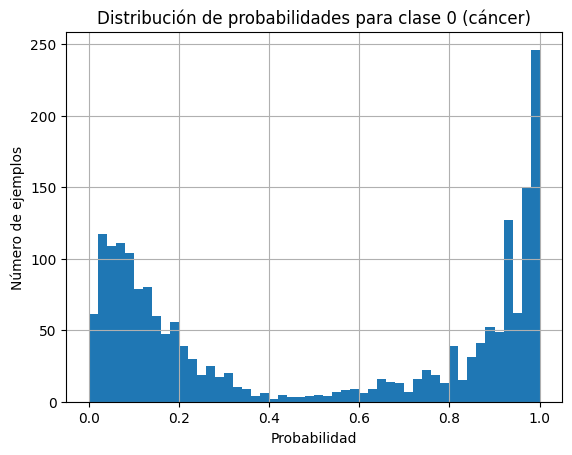

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Métricas en test
y_pred = clf.predict(X_test)
print("📊 Classification Report (Test):\n")
print(classification_report(y_test, y_pred))

# Accuracy en entrenamiento y test
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)
print(f"✅ Accuracy en entrenamiento: {acc_train:.4f}")
print(f"✅ Accuracy en test: {acc_test:.4f}")

# Validación cruzada
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"🔁 Validación cruzada (media): {cv_scores.mean():.4f}")
print(f"     Fold scores: {cv_scores}")

# Visualizar la distribución de probabilidades
probs_test = clf.predict_proba(X_test)[:, 0]  # clase 0 = adenocarcinoma
plt.hist(probs_test, bins=50)
plt.title("Distribución de probabilidades para clase 0 (cáncer)")
plt.xlabel("Probabilidad")
plt.ylabel("Número de ejemplos")
plt.grid(True)
plt.show()


In [9]:
import joblib
import os

# Crear carpeta si no existe
os.makedirs("modelos_guardados", exist_ok=True)

# Guardar el modelo
joblib.dump(clf, "modelos_guardados/random_forest_colon.pkl")

# (Opcional) Guardar también los datos de entrenamiento
joblib.dump((X_train, y_train), "modelos_guardados/datos_entrenamiento_rf.pkl")

print("✅ Modelo guardado correctamente en la carpeta 'modelos_guardados'")


✅ Modelo guardado correctamente en la carpeta 'modelos_guardados'
